In [1]:
import imp
import uproot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
helper = imp.load_source('helpfunction','/home/tmettler/Desktop/uBoone/do_plots/helpfunction.py')
#import /home/tmettler/Desktop/uBoone/do_plots/helpfunction as helper
from __future__ import division
globale = imp.load_source('globale','/home/tmettler/Desktop/uBoone/do_plots/globale.py')


import collections
NuCC = imp.load_source('NuCC_function','/home/tmettler/Desktop/uBoone/do_plots/NuCC_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [3]:
# Load input files

inputdir = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/'
outputdir = inputdir+'NumuCC_muon_cut/' 
outputdir_png, outputdir_root = NuCC.prepareOutput(outputdir)

filename_overlay = 'NuCCana_Overlay_V18_V3.root'
filename_data = 'NuCCana_Data_V16_V3.root'
filename_ext = 'NuCCana_Ext_V18_V3.root'
filename_dirt = 'NuCCana_Dirt_V20_V3.root'
    
tree_name = 'numuCCAna'

In [4]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)

#pot_data =      9.036e+18 # tor860_wcut
#data_trigger = 1942081.0 #4743794 # 1987072.0 # E1DCNT_wcut
#ext_trigger =  25882118.0  #2120135 #5685315 # EXT

pot_data =     8.039e+18 # tor860_wcut
data_trigger = 1942081.0 # E1DCNT_wcut
ext_trigger =  25882118.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]*1.3
scale[overlay] = scale[overlay]*1.3
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	967268
Data: Number of Entries:	34835
Ext: Number of Entries:		302778
Dirt: Number of Entries:	96465

POT: 
Data:		8.039e+18
Ext:		0
Overlay:	1.21191661343e+21
Dirt:		2.95232189919e+20

Scalefactors: 
Data:		1.0
Ext:		0.0750356288461
Overlay:	0.00862328305772
Dirt:		0.0353982402897


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [5]:
if 1:
    filename_overlay = 'NuCCana_Overlay_V18_V3.rootout.root'
    filename_data = 'NuCCana_Data_V16_V3.rootout.root'
    filename_ext = 'NuCCana_Ext_V18_V3.rootout.root'
    filename_dirt = 'NuCCana_Dirt_V20_V3.rootout.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]*1.3
    scale_out[overlay_out] = scale_out[overlay_out]*1.3

Overlay: Number of Entries:	967267
Data: Number of Entries:	34834
Ext: Number of Entries:		302777
Dirt: Number of Entries:	96464



In [6]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG==13 && MCle_purity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG!=13 && MCle_purity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_purity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [7]:
for x in sample_out:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    #x.SetAlias('muon','(key_muprotratio==track_key)')
    
num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    #num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
#tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
#overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [8]:
# Load the global variables for access of functions

NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [9]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [10]:
track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")


True

In [11]:
NuCC.pdg_content_out('fidVol && muon')

Total number of entries:  283618.0
PDG:  13 	=	62.2% ,	error: 0.1% ,	number:  176310.0
PDG:  -1 	=	13.2% ,	error: 0.1% ,	number:  37501.0
PDG:  2212 	=	11.4% ,	error: 0.1% ,	number:  32195.0
PDG:  211 	=	4.3% ,	error: 0.0% ,	number:  12314.0
PDG:  2112 	=	3.6% ,	error: 0.0% ,	number:  10291.0
PDG:  22 	=	2.4% ,	error: 0.0% ,	number:  6850.0
PDG:  -211 	=	2.2% ,	error: 0.0% ,	number:  6261.0
PDG:  -13 	=	0.5% ,	error: 0.0% ,	number:  1318.0
PDG:  11 	=	0.1% ,	error: 0.0% ,	number:  322.0
PDG:  321 	=	0.0% ,	error: 0.0% ,	number:  130.0
PDG:  -11 	=	0.0% ,	error: 0.0% ,	number:  50.0
PDG:  -321 	=	0.0% ,	error: 0.0% ,	number:  3.0


In [12]:
NuCC.printEff_out('fidVol && muon')

Efficiency for cut:  fidVol && muon
Rejection on each sample:
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:		66.84%
Purity:			33.76%
Purity*Efficiency	22.56

Amount of     ext:	35.82%
Amount of overlay:	59.41%
Amount of    dirt:	4.77%

Signal definition=  numu_lowpur: 2.79%	(4.70%)
Signal definition=   numu_other: 0.56%	(0.94%)
Signal definition=    numu_nomu: 4.40%	(7.41%)
Signal definition=      numu_ov: 9.52%	(16.02%)
Signal definition=  numu_signal: 33.76%	(56.82%)
Signal definition=      numu_nc: 8.37%	(14.09%)


In [13]:
NuCC.printEff_out('fidVol && muon && TrackLength>8')

Efficiency for cut:  fidVol && muon && TrackLength>8
Rejection on each sample:
Keep of     ext:	88.78%	 reject:	11.22%
Keep of overlay:	91.50%	 reject:	8.50%
Keep of    dirt:	85.30%	 reject:	14.70%

Efficiency:		66.63%
Purity:			37.30%
Purity*Efficiency	24.85

Amount of     ext:	35.24%
Amount of overlay:	60.25%
Amount of    dirt:	4.51%

Signal definition=  numu_lowpur: 2.15%	(3.57%)
Signal definition=   numu_other: 0.49%	(0.82%)
Signal definition=    numu_nomu: 4.66%	(7.74%)
Signal definition=      numu_ov: 8.89%	(14.76%)
Signal definition=  numu_signal: 37.30%	(61.91%)
Signal definition=      numu_nc: 6.74%	(11.20%)


In [15]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')

Efficiency for cut:  fidVol && muon && TrackLength>8 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut
Rejection on each sample:
Keep of     ext:	40.66%	 reject:	59.34%
Keep of overlay:	77.00%	 reject:	23.00%
Keep of    dirt:	50.45%	 reject:	49.55%

Efficiency:		59.49%
Purity:			47.91%
Purity*Efficiency	28.50

Amount of     ext:	23.22%
Amount of overlay:	72.94%
Amount of    dirt:	3.84%

Signal definition=  numu_lowpur: 1.78%	(2.44%)
Signal definition=   numu_other: 0.63%	(0.86%)
Signal definition=    numu_nomu: 5.23%	(7.17%)
Signal definition=      numu_ov: 8.76%	(12.01%)
Signal definition=  numu_signal: 47.91%	(65.68%)
Signal definition=      numu_nc: 8.64%	(11.84%)


In [16]:
NuCC.pdg_content33_out('fidVol && muon && TrackLength>32 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')

Total number of entries:  0.0


Error in <TTreeFormula::Compile>:  Bad numerical expression : "MCTrackPDG"
Info in <TSelectorDraw::AbortProcess>: Variable compilation failed: {MCTrackPDG,fidVol && muon && TrackLength>32 && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut}


In [17]:
crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)


True

In [18]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8')

Efficiency for cut:  fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8
Rejection on each sample:
Keep of     ext:	37.43%	 reject:	62.57%
Keep of overlay:	73.10%	 reject:	26.90%
Keep of    dirt:	44.76%	 reject:	55.24%

Efficiency:		58.12%
Purity:			49.77%
Purity*Efficiency	28.93

Amount of     ext:	22.74%
Amount of overlay:	73.64%
Amount of    dirt:	3.62%

Signal definition=  numu_lowpur: 1.73%	(2.35%)
Signal definition=   numu_other: 0.62%	(0.84%)
Signal definition=    numu_nomu: 5.14%	(6.98%)
Signal definition=      numu_ov: 8.26%	(11.21%)
Signal definition=  numu_signal: 49.77%	(67.59%)
Signal definition=      numu_nc: 8.12%	(11.02%)


In [19]:
#NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8 && TrackLength>20')

In [20]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8 && TrackLength>32')
# 20cm = 150MeV MC momentum, 32 = 180 MeV

Efficiency for cut:  fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8 && TrackLength>32
Rejection on each sample:
Keep of     ext:	32.89%	 reject:	67.11%
Keep of overlay:	64.44%	 reject:	35.56%
Keep of    dirt:	34.25%	 reject:	65.75%

Efficiency:		56.02%
Purity:			54.72%
Purity*Efficiency	30.65

Amount of     ext:	22.79%
Amount of overlay:	74.05%
Amount of    dirt:	3.16%

Signal definition=  numu_lowpur: 1.81%	(2.45%)
Signal definition=   numu_other: 0.60%	(0.82%)
Signal definition=    numu_nomu: 4.66%	(6.30%)
Signal definition=      numu_ov: 7.42%	(10.02%)
Signal definition=  numu_signal: 54.72%	(73.90%)
Signal definition=      numu_nc: 4.83%	(6.52%)


In [21]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<24')

Efficiency for cut:  fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8                && TrackLength>32 && TrackPID_chimuon<24
Rejection on each sample:
Keep of     ext:	26.61%	 reject:	73.39%
Keep of overlay:	57.60%	 reject:	42.40%
Keep of    dirt:	30.07%	 reject:	69.93%

Efficiency:		53.21%
Purity:			59.47%
Purity*Efficiency	31.64

Amount of     ext:	21.09%
Amount of overlay:	75.73%
Amount of    dirt:	3.18%

Signal definition=  numu_lowpur: 1.70%	(2.24%)
Signal definition=   numu_other: 0.61%	(0.81%)
Signal definition=    numu_nomu: 3.34%	(4.41%)
Signal definition=      numu_ov: 7.12%	(9.41%)
Signal definition=  numu_signal: 59.47%	(78.52%)
Signal definition=      numu_nc: 3.49%	(4.61%)


In [36]:
NuCC.printEff_out('fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<24')

Efficiency for cut:  fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8                && TrackLength>32 && TrackPID_chimuon<24
Rejection on each sample:
Keep of     ext:	26.61%	 reject:	73.39%
Keep of overlay:	57.60%	 reject:	42.40%
Keep of    dirt:	30.07%	 reject:	69.93%

Efficiency:		53.21%
Purity:			59.47%
Purity*Efficiency	31.64

Amount of     ext:	21.09%
Amount of overlay:	75.73%
Amount of    dirt:	3.18%

Signal definition=  numu_lowpur: 1.70%	(2.24%)
Signal definition=   numu_other: 0.61%	(0.81%)
Signal definition=    numu_nomu: 3.34%	(4.41%)
Signal definition=      numu_ov: 7.12%	(9.41%)
Signal definition=  numu_signal: 59.47%	(78.52%)
Signal definition=      numu_nc: 3.49%	(4.61%)


In [23]:
nenner = 'numu_true'
zahler = 'fidVol && muon && numu_true'
cut = 'fidVol && muon'
NuCC.plot_eff_outV2(nenner,zahler,cut,'initial','initial')

Efficiency:	66.84%
Purity:		33.76%


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_energyinitial.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_energyinitial.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_thetainitial.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_thetainitial.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_phiinitial.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_phiinitial.root has been created
Info in <TCanvas::Pr

In [35]:
nenner = 'numu_true'
zahler = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<24 && numu_true'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<24'
NuCC.plot_eff_outV2(nenner,zahler,cut,'petestV2','petestV2')

Efficiency:	53.21%
Purity:		59.47%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_energypetestV2.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_energypetestV2.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_thetapetestV2.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_thetapetestV2.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_phipetestV2.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_phipetestV2.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_1

In [34]:
nenner = 'fidVol && muon && numu_true'
zahler = 'fidVol && muon && TrackLength>32 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<24 && numu_true'
cut = 'fidVol && muon && TrackLength>32 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>32 && TrackPID_chimuon<24'
NuCC.plot_eff_outV2(nenner,zahler,cut,'Toms cut','Toms cut')

Efficiency:	53.21%
Purity:		59.47%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_energyToms cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_energyToms cut.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_thetaToms cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_thetaToms cut.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_phiToms cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_phiToms cut.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_1

In [33]:
nenner = 'fidVol && muon && numu_true'
zahler = 'fidVol && muon && TrackLength>32 && crt_tom_cut && TrackPID_chimuon<24 && numu_true'
cut = 'fidVol && muon && TrackLength>32 && crt_tom_cut && TrackPID_chimuon<24'
NuCC.plot_eff_outV2(nenner,zahler,cut,'CRT cut','CRT cut')

Efficiency:	53.85%
Purity:		59.05%


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_energyCRT cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_energyCRT cut.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_thetaCRT cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_thetaCRT cut.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/h_eff_phiCRT cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/h_eff_phiCRT cut.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/N

Normalization (data-ext)/mc =  0.989223126109
Normalization (data)/(mc +ext) =  0.991499657358


Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/NuScore_muon_cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_

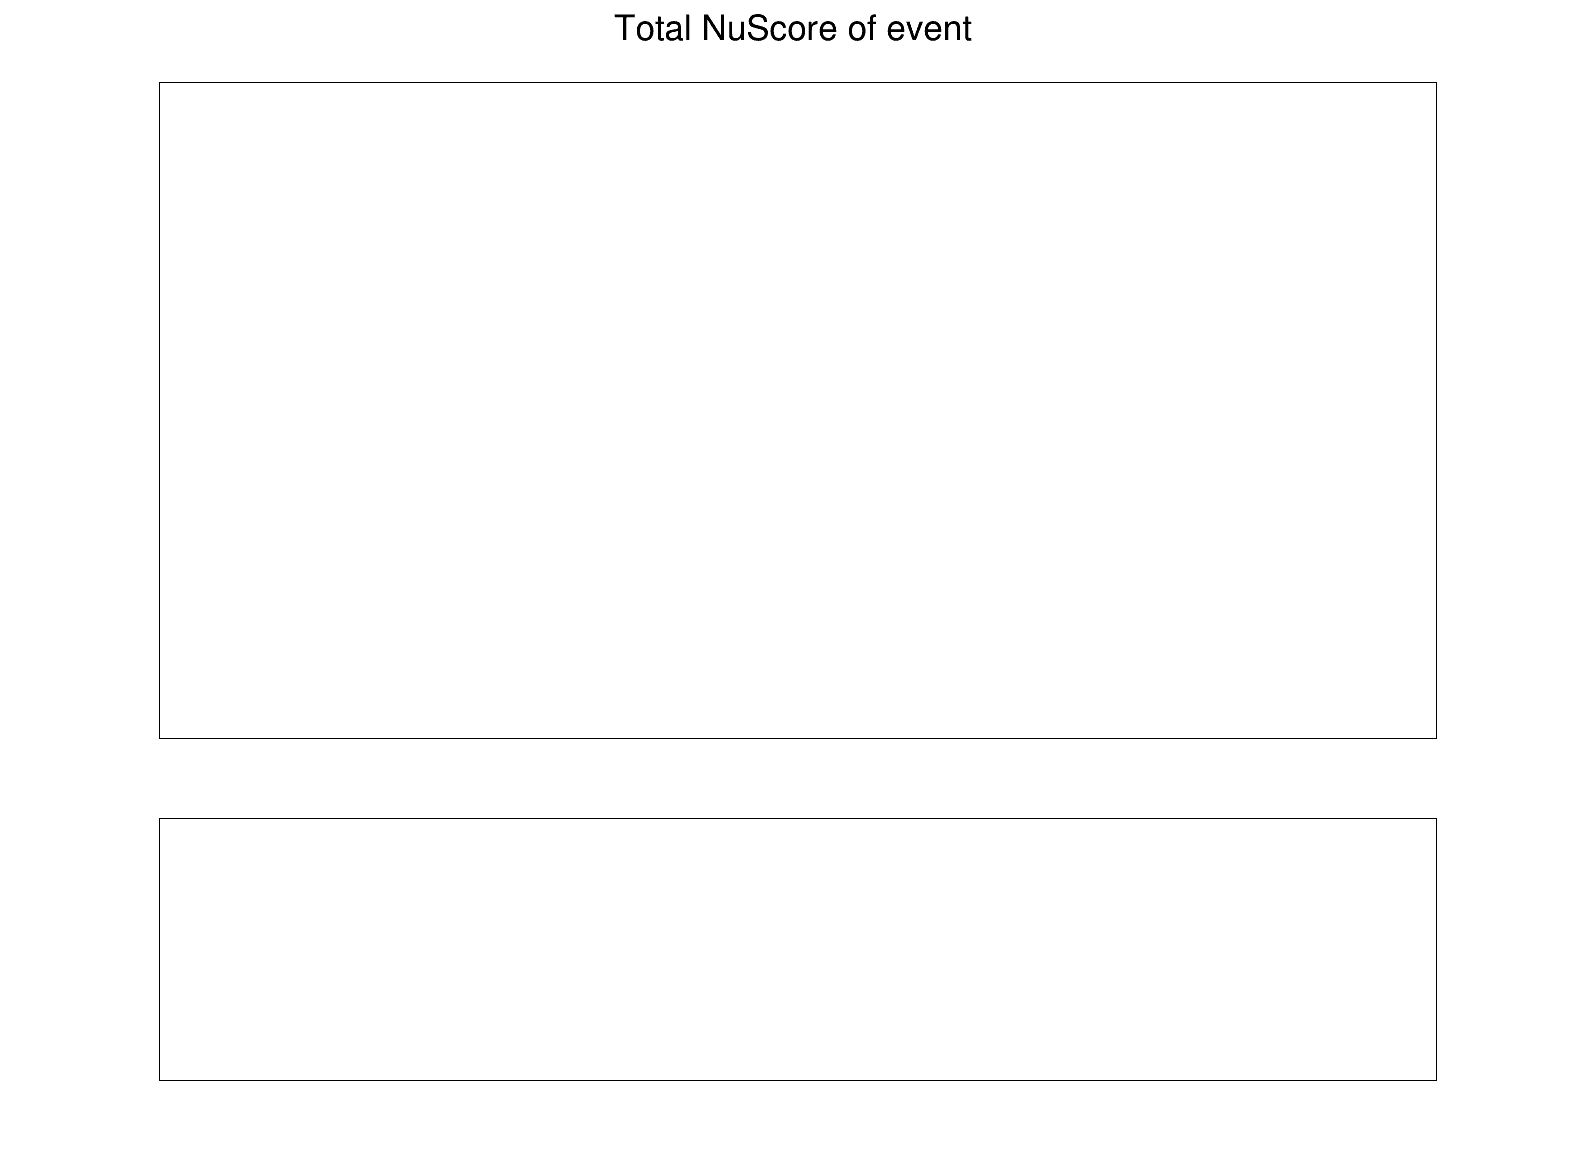

In [49]:
cut = 'fidVol && muon && TrackLength>32 && crt_tom_cut && TrackPID_chimuon<24'
name = '_muon_cut'
#NuCC.make_stacked_histo_plot_out(cut + ' && TrackTheta!=-9','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta'+name)
#NuCC.make_stacked_histo_plot_out(cut,'Nu_Vz_sce','Reco. Nu vertex Z position [cm]',-20,1020,50,'NuVz_sce'+name)
NuCC.make_stacked_histo_plot_out(cut,'NuScore','Total NuScore of event',0,1,20,'NuScore'+name)


In [27]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Variation of cut on: TrackLength
Maximum value:  30.6572437286
Bin:  35  -> Value:  34.0


Warning in <TROOT::Append>: Replacing existing TH1: h_eff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_effpur (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/TrackLength.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/TrackLength.root has been created


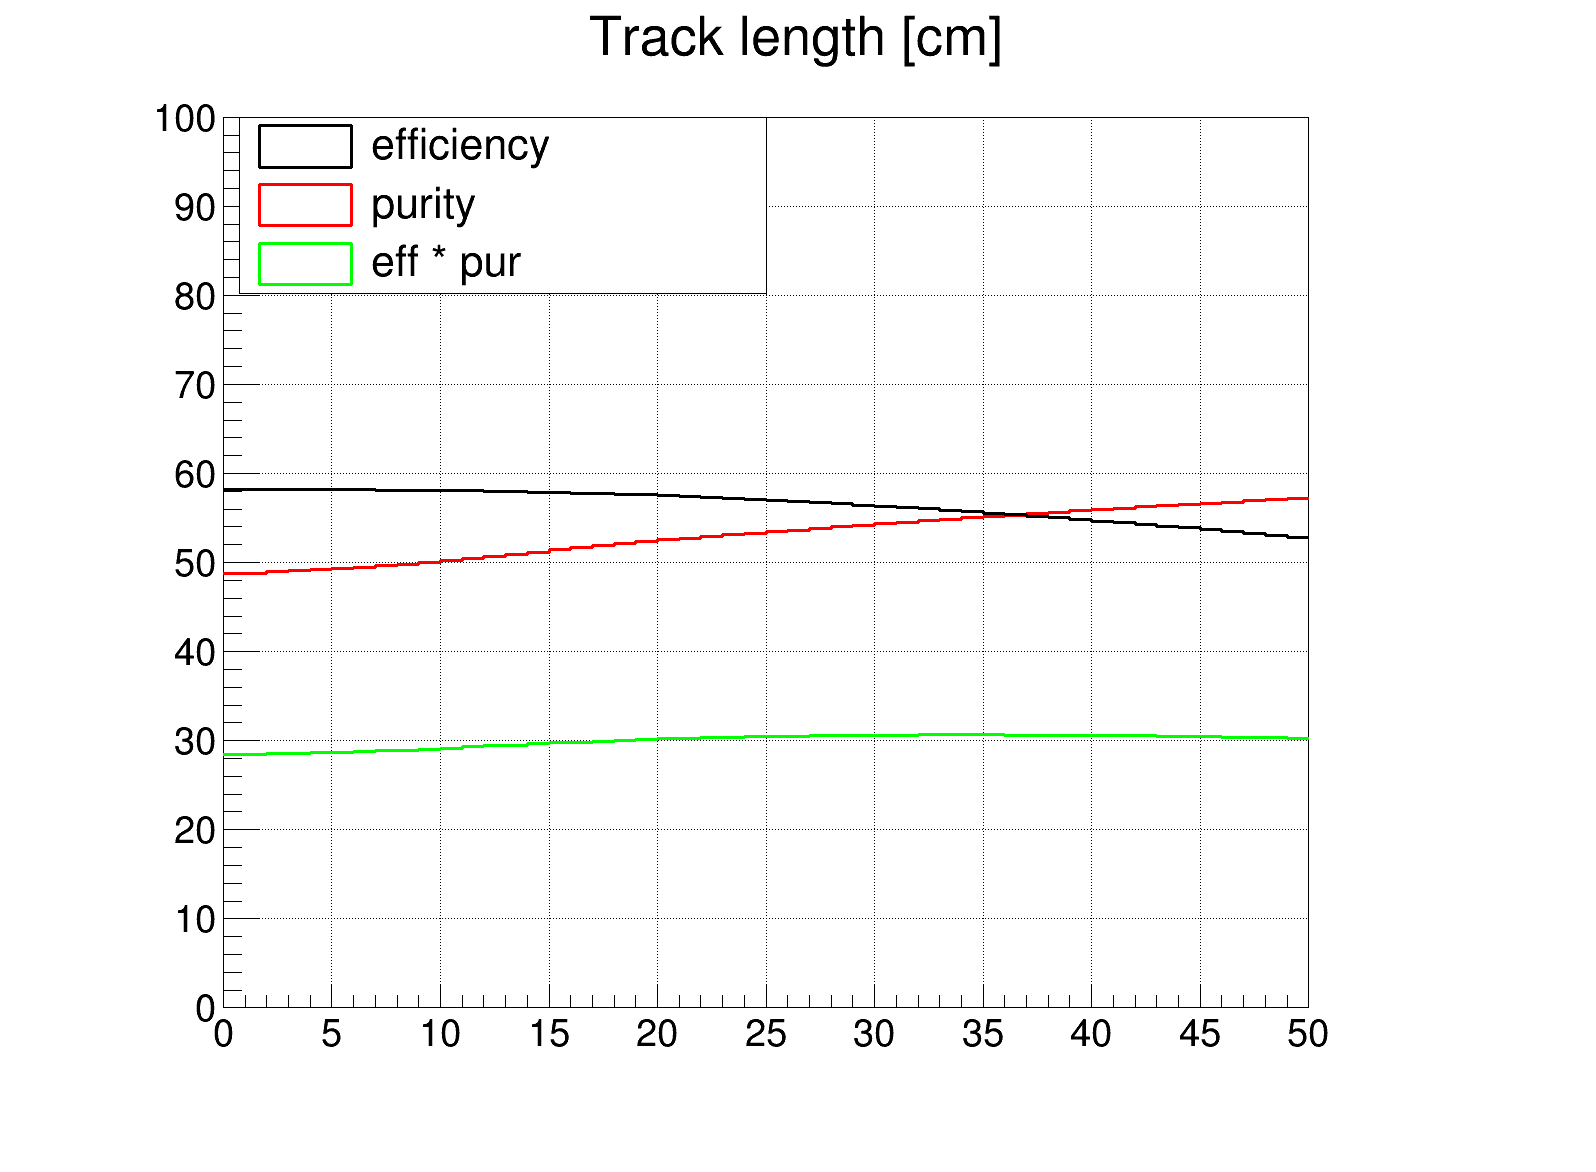

In [29]:
value = 'TrackLength'
xbins = 50
xstart = 0
xend = 50
step = (xend-xstart)/xbins
title = 'Track length [cm]'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && TrackScore>0.8 && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

Variation of cut on: TrackPID_chimuon
Maximum value:  31.6403312683
Bin:  25  -> Value:  24.0


Warning in <TROOT::Append>: Replacing existing TH1: h_eff (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_effpur (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//png/TrackPID_chimuon.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17_V2/NumuCC_muon_cut//root/TrackPID_chimuon.root has been created


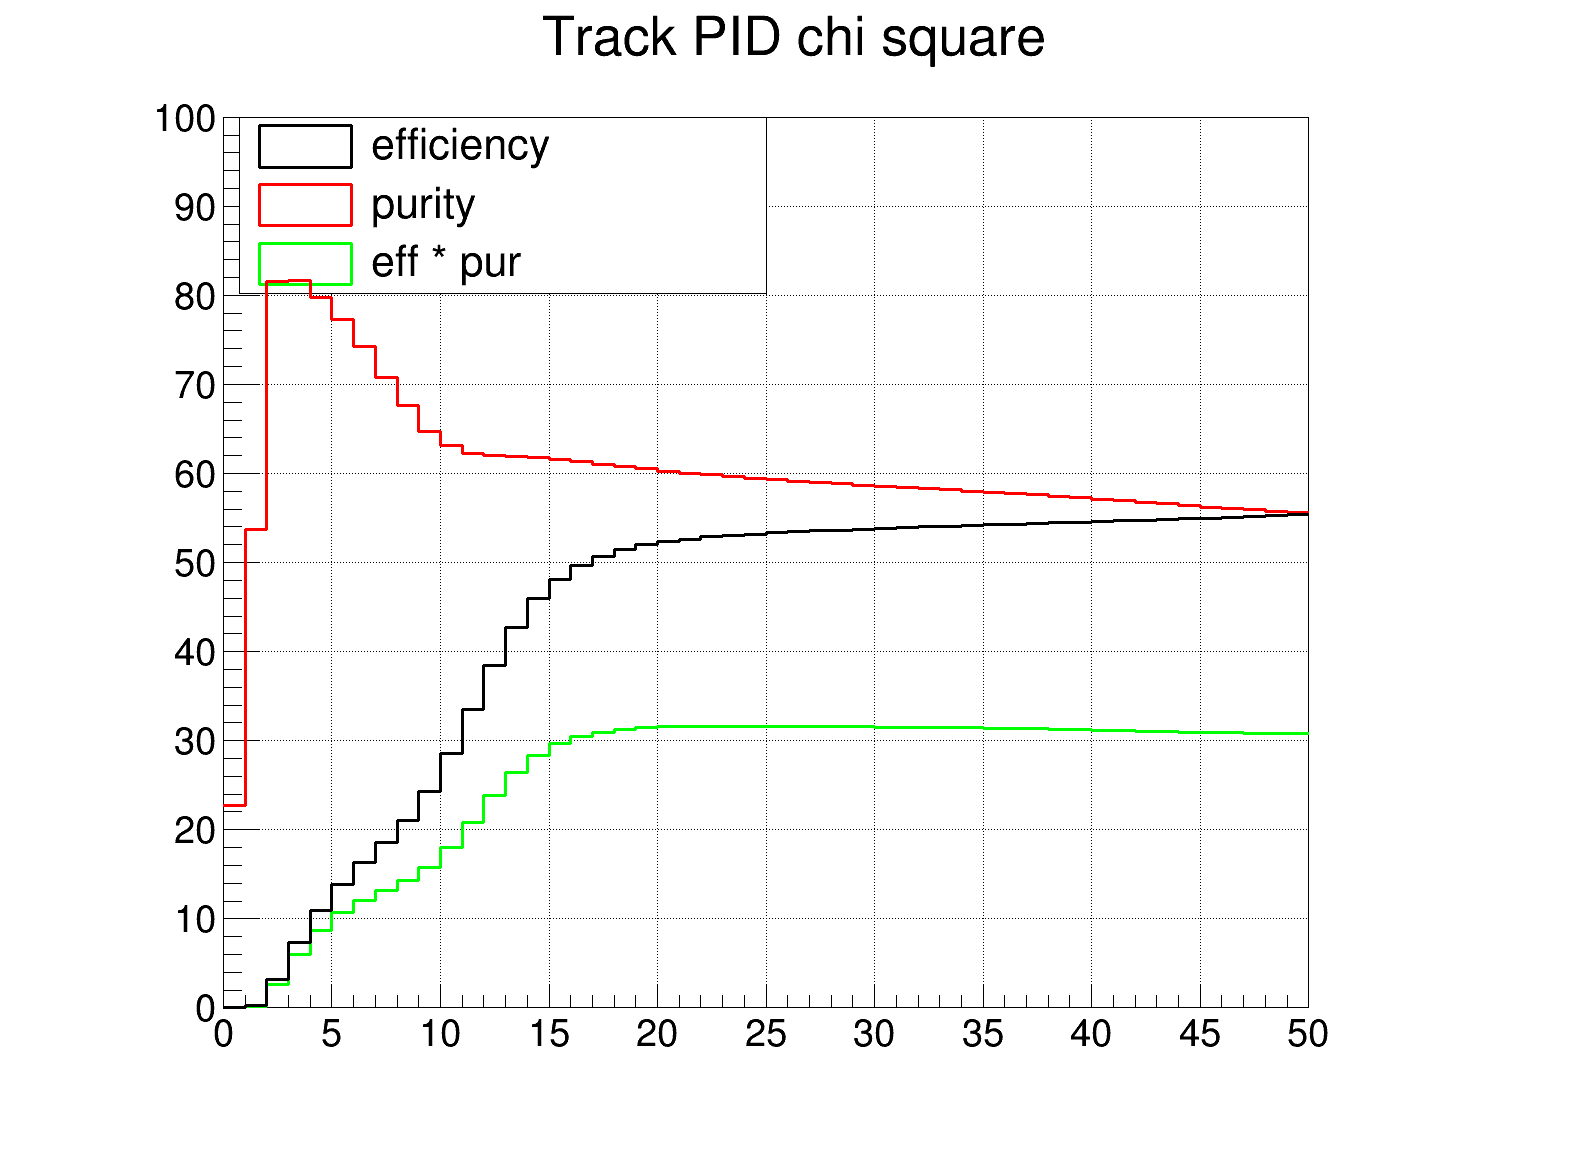

In [30]:
value = 'TrackPID_chimuon'
xbins = 50
xstart = 0
xend = 50
step = (xend-xstart)/xbins
title = 'Track PID chi square'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && TrackScore>0.8 && \
        TrackLength>32 && ('+value+'<('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step